# Sentence Alignment

#### Charlie Liou

In [218]:
import re, string, math
import os, glob
import numpy as np
import pandas as pd, matplotlib.pyplot as plt
from itertools import chain
from scipy.optimize import least_squares
from scipy.stats import norm
from IPython.display import Image
%matplotlib inline

TED data directory:

## What algorithm to use?

In [152]:
def eng_length(s, which = "EDA"):
    exclude = set(string.punctuation + "—")
    if which == "EDA":
        return "".join(c for c in s if c not in exclude).split(" ")
    else:
        temp = [re.sub("\s{1,}", " ", "".join(c for c in x if c not in exclude).strip()).split(" ") for x in s]
        return [len(x) for x in temp if x != ['']]

In [153]:
def zhtw_length(s, which = "EDA"):
    zhtwpunct = set(string.punctuation + "〈〉「」。，—")
    if which == "EDA":
        num = 0
        for i in [[m.start(), m.end()] for m in re.finditer("([A-z])\w+(-\w+)?", s)]:
            s = s[:i[0] - num] + "我" + s[i[1] - num + 1:] 
            num += i[1] - i[0]
        return([x for x in list(chain.from_iterable("".join(ch for ch in s if ch not in zhtwpunct))) 
                if x.strip() != ""])
    else:
        for x in range(len(s)):
            num = 0
            for i in [[m.start(), m.end()] for m in re.finditer("([A-z])\w+(-\w+)?", s[x])]:
                s[x] = s[x][:i[0] - num] + "我" + s[x][i[1] - num + 1:] 
                num += i[1] - i[0]
            s[x] = [y for y in list(chain.from_iterable("".join(ch for ch in s[x] if ch not in zhtwpunct))) 
                if y.strip() != ""]
        return [len(x) for x in s if x != []]

In [5]:
def paragraph_length(files):
    a = ["eng\tzhtw\tdiff"]
    for x in files:
        l = list(chain.from_iterable([i.split("\t") for i in open(x, "r", encoding = "utf-8").read().split("\n")]))
        eng = len(eng_length(l[4], "EDA"))#count_chars(eng_length(l[4]))#len(eng_length(l[4]))
        zhtw = len(zhtw_length(l[5]))
        a.append(str(eng) + "\t" + str(zhtw) + "\t" + str((zhtw - eng) ** 2))
    f = open("talk_length.txt", "w")
    f.write("\n".join(a))
    f.close()

paragraph_length(files)

In [6]:
talklength = np.array([i.split("\t") for i in open("talk_length.txt", "r", encoding = "utf-8").read().split("\n")])
df = pd.DataFrame(talklength[1:], columns = talklength[0]).astype(int)

This next graph shows that the number of English words and the number of Chinese characters per TED talk show a high positive correlation.

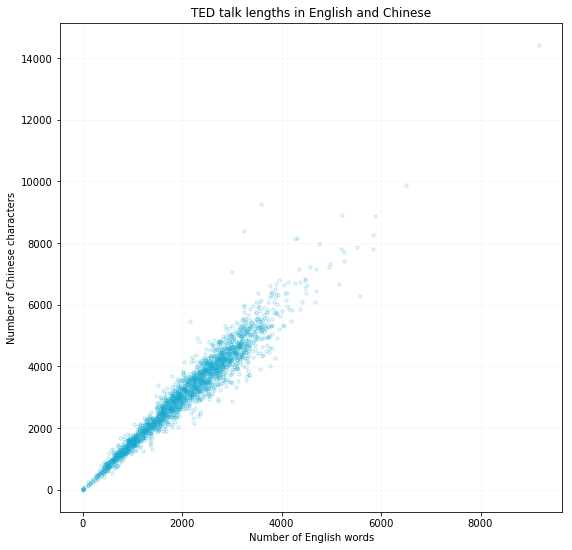

In [7]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)


ax.plot(df["eng"], df["zhtw"], marker = ".", ls = "None", mfc = "None", alpha = 0.3, c = "#16a9d0")
ax.set_title("TED talk lengths in English and Chinese")
ax.set_xlabel("Number of English words")
ax.set_ylabel("Number of Chinese characters")
ax.grid(alpha = 0.1);

In fact, the Pearson correlation is around 0.9689. A sentence alignment program that takes advantage of a positive correlation between sentence length for both languages would be fitting.

In [8]:
def corr(x, y):
    return ((x * y).mean() - x.mean() * y.mean()) / (np.sqrt(x.var()) * np.sqrt(y.var()))

corr(df["eng"], df["zhtw"])

0.96882190197080353

## Gale-Church

Let $L_1$ represent the language with less characters per TED talk. In this case, $L_1$ is English so $L_2$ is Chinese. Define a discrete random variable $X$ where each English word in $L_1$ maps to a random number of Chinese characters in $L_2$. Assume $X$ is i.i.d, $X \sim \mathcal{N}(c, s^2)$. By definition, $c$ is the expected number of Chinese characters in $L_2$ per English word in $L_1$, $s^2$ is the variance of Chinese characters in $L_2$ per English word in $L_1$. Define 

$$\delta = \dfrac{l_2 - c l_1}{\sqrt{s\dfrac{(l_1 + cl_2)}{2}}}$$

where $l_1$ is the length of the English text under consideration, $l_2$ defined similarly for Chinese. Note that $\delta \sim \mathcal{N}(0, 1)$. 

In the original paper, the denominator contained $l_1$ instead of $\dfrac{(l_1 + cl_2)}{2}$.

$c$ is estimated by dividing the number of Chinese characters in the TED talks by the number of English words in the TED talks:

In [9]:
c = sum(df["zhtw"]) / sum(df["eng"])

$s^2$ is estimated with a regression of the square of the difference between English and Chinese word/character lengths per talk and number of English words per talk. Two things to note:
- Many observations that are outliers / have high leverage 
- The relationship between English talk length and the square of the difference seems to be curved

The original paper by Gale & Church utilized a robust linear regression. We will have to settle with a robust linear regression until I figure how to get $s^2$ from a robust polynomial regression.

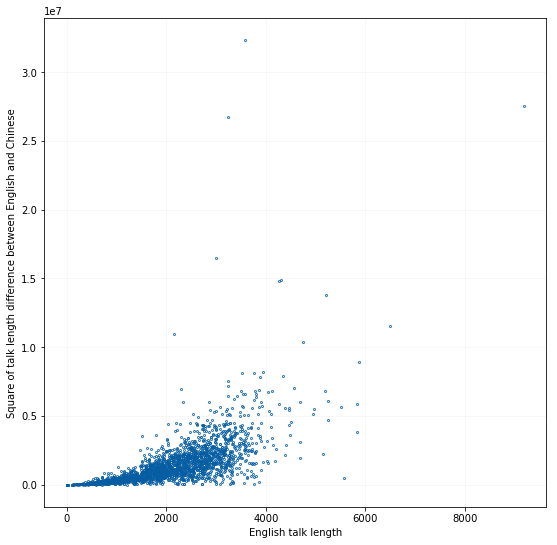

In [10]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)

ax.plot(df["eng"], df["diff"], marker = "o", ls = "None", mfc = "None", ms = 2, alpha = 0.8, c = "#065da2")
ax.grid(alpha = 0.1)
ax.set_ylabel("Square of talk length difference between English and Chinese")
ax.set_xlabel("English talk length");

### Robust regression

For the robust regression, I opted for a `soft_l1` penalization. All this does it take the least squares formulation

$$\begin{equation}
\hat{\beta}_{\textrm{LS}} = \arg\min_x\frac{1}{2} \sum_{i=1}^n  (\epsilon_{i}(\beta))^2
\end{equation}$$

apply a function $\rho$ onto each error term 

$$\begin{equation}
\hat{\beta}_{\textrm{M}} = \arg\min_x\frac{1}{2} \sum_{i=1}^n  \rho\left((\epsilon_{i}(\beta))^2\right)
\end{equation}$$

where 

$$\rho(z) = 2 (\sqrt{1 + z} - 1)$$

which is a continuous approximation to the $L_1$-estimator

$$\begin{equation*}   \hat{\beta}_{\textrm{LAD}}=\arg\min_{\beta}\sum_{i=1}^{n}\mid\epsilon_{i}(\beta)\ \mid \end{equation*}$$

We utilize $\rho$ because the $L_1$ estimator is non-differentiable. Consider the $L_1$ ball centered at the origin in $\mathbb{R}^2$: $\mathcal{B}_r(\vec{0}) = \{x \in \mathbb{R}^2 \mid d(0, x) < r\}$. The sharp corners along the axes fail differentiability. As such, forcing the function to be continuous guarantees differentiability.

In [11]:
def residuals(coeffs, x, y = 0):
    return (coeffs[0] + coeffs[1] * x) - y

x_train = df["eng"]
y_train = df["diff"]
resid = least_squares(residuals, np.zeros(4), args = (x_train, y_train))
resid_robust = least_squares(residuals, np.zeros(4), loss='soft_l1', args = (x_train, y_train))

Below is a plot of both least squares and the `soft_l1` approximation:

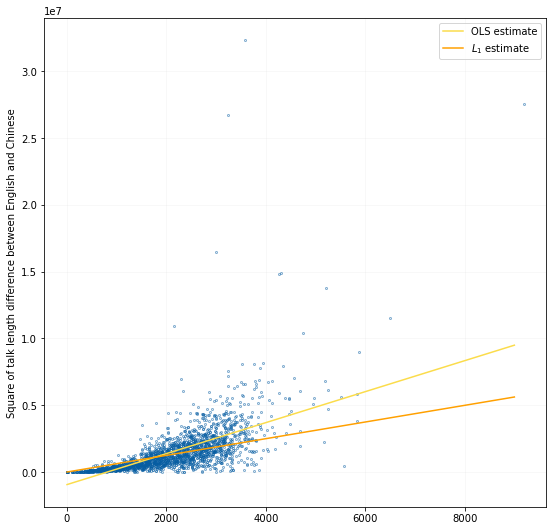

In [12]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)

ax.plot(df["eng"], df["diff"], marker = "o", ls = "None", mfc = "None", ms = 2, alpha = 0.5, c = "#065da2")
ax.grid(alpha = 0.1)
ax.set_ylabel("Square of talk length difference between English and Chinese")
one, = ax.plot(np.linspace(0,9000,9000), [residuals(resid.x, i) for i in np.linspace(0,9000,9000)],
               label = "OLS estimate", c = "#fbdc4b")
two, = ax.plot(np.linspace(0,9000,9000), [residuals(resid_robust.x, i) for i in np.linspace(0,9000,9000)],
               label = "$L_1$ estimate", c = "#ffa000")

plt.legend(handles = [one, two]);

Let us now calculate $\delta$. If it seems to follow a $\mathcal{N}(0, 1)$ distribution, Gale-Church alignment would be proper.

In [223]:
s = np.sqrt(resid_robust.x[1])
m = (df["eng"] + df["zhtw"] * c) / 2
delta = (df["zhtw"] - c * df["eng"]) / (np.sqrt(m * s))

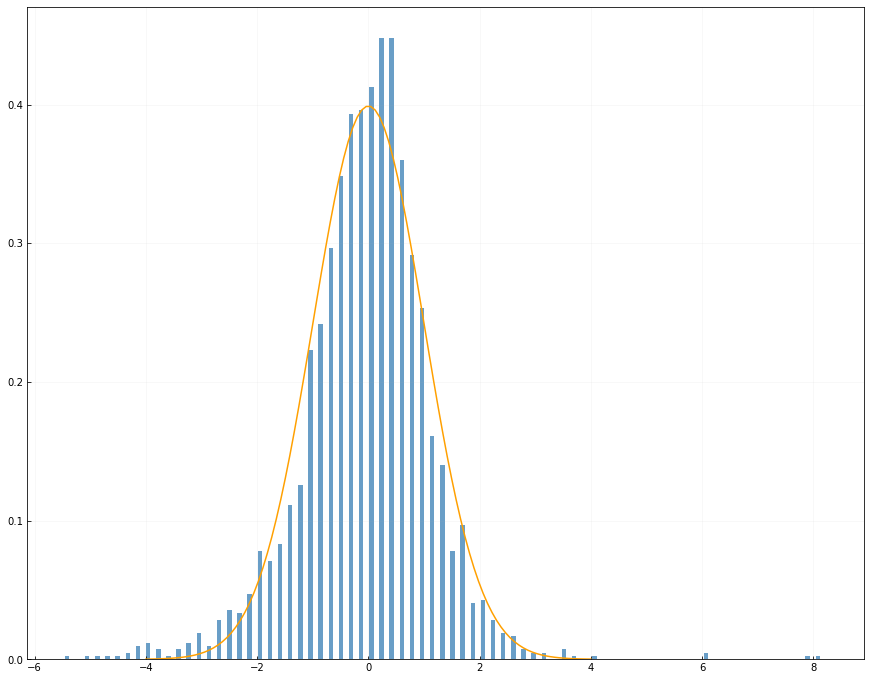

In [224]:
fig = plt.figure(figsize = (15,12))
ax = fig.add_subplot(111)

ax.grid(alpha = 0.1)
ax.tick_params(which = "both", direction = "in")
ax.hist(delta, bins = 75, alpha = 0.6, width = 0.08, normed = True, color = "#065da2")
ax.plot(np.linspace(-4,4,100), norm.pdf(np.linspace(-4,4,100)), c = "#ffa000");

### Alignment

Edge case: no punctuation in the Chinese transcript:
- Solution: Rescrape data but with "\n" replaced with spaces. Split on space (" "), ALIGN (NOT GC) by checking with english sentences.... Then run Gale-Church: May need to check different probabilities

In [295]:
from nltk.translate import gale_church

In [301]:
def write_aligned(seng, szhtw, name):
    e, z, etrack, ztrack = [], [], 0, 0
    temp = gale_church.align_blocks(seng, szhtw)
    print(temp[len(temp) - 1])
    for x in temp:
        #print(x, len(e), len(z))
        if (x[0] > (len(e) + etrack - 1)):
            #print(x, etrack, e, z)
            if x[1] == (len(z) + ztrack - 1): #multiple english, one chinese
                etrack += 1
                e[x[0] - etrack] += "." + eng[x[0]]
            else:
                e.append(eng[x[0]])
                z.append(zhtw[x[1]])
        elif x[1] > (len(z) + ztrack - 1): 
            if x[0] == (len(e) + etrack - 1): #multiple chinese, one english
                ztrack += 1
                z[x[1] - ztrack] += "。" + zhtw[x[1]]
            else:
                e.append(eng[x[0]])
                z.append(zhtw[x[1]])
    
    print(len(e), len(z))
                
    file = open(name + "_engalign.txt", "w", encoding = "utf-8")
    for i in e: file.write(i + "\n")
    file.close()
    
    file = open(name + "_zhtwalign.txt", "w", encoding = "utf-8")
    for i in z: file.write(i + "\n")
    file.close()
    

In [305]:
re.split("\.|:", "lol: lo. lol :")

['lol', ' lo', ' lol ', '']

In [306]:
for file in files:
    t = list(chain.from_iterable([i.split("\t") for i in open(file, "r", encoding = "utf-8").read().split("\n")]))
    eng = re.split("(?<![A-Z])(?<![A-Z][a-z])(?<![A-Z][a-z][a-z])\.", t[4])
    zhtw = re.split("。|：", t[5])
    seng = eng_length(eng[:], " ")
    szhtw = zhtw_length(zhtw[:], " ")
    write_aligned(seng, szhtw, t[3])

(67, 62)
61 61
(161, 169)
150 150
(35, 18)
19 19
(13, 11)
12 12
(60, 70)
59 59
(0, 0)
1 1
(127, 127)
122 122
(198, 200)
191 191
(76, 82)
77 77
(86, 135)
87 87
(104, 104)
98 98
(81, 80)
76 76
(8, 15)
6 6
(163, 34)
6 6
(62, 74)
62 62


IndexError: list index out of range

In [308]:
t[5]

'我有個朋友是政治學家幾個月前 他告訴我這個月大概是什麼光景他說：「財政懸崖快來了。」估計在 2013 年初到來兩黨都必須解決這問題但沒有一方願意先採取行動也沒有一方想要在危機到來以前解決所以他說，在十二月時你會看到一堆激烈爭執、協商破局一些在電話上相談不歡的報導有人說什麼結果都沒有到了聖誕節或是新年的時候我們會聽說：「他們解決所有問題了。」他幾個月前告訴我 他有98%的把握他們會解決問題今天我收到他的電子郵件說「好吧，大致上猜的沒錯但現在我只有80%的把握他們會解決這件事情。」 所以我開始思考，我喜歡研究美國歷史上這種分歧的時期不同黨派彼此爭論不休經濟正值崩盤的邊緣 早期最有名的爭論是亞歷山大•漢彌爾頓和湯瑪斯•傑弗遜對於美元會如何以及 該用什麼方式儲存而爭論亞歷山大•漢彌爾頓說「我們需要一個中央銀行，美國第一銀行不然美元就毫無價值了」湯瑪斯•傑弗遜則說「這經濟體系行不通，人民不信這一套」「他們才剛推翻一個王朝才不會接受一個中央集權組織。」這個爭論奠定了美國前期一百五十年的經濟每一次，當不同黨派說「老天，經濟要崩盤了。」有些人就開始盡情揮霍把錢花在所有想買的東西上 先來了解一下我們現在的處境快速地回顧一下有人叫我別叫它財政懸崖因為黨派色彩太重我記不得 到底誰贊成誰反對有人說 應該叫財政斜坡才對或稱為緊縮危機但就有人反對 說這樣反而更不中立所以我乾脆叫它設立自我導致 自我毀滅沒有明確期限的方案來解決不可避免的問題這就是一個不可避免的問題的真實模樣這是美國國債百分比圖佔整體經濟 國內生產毛額(GDP)的比例高低藍色虛線代表國會預算局最樂觀的估計如果國會什麼都沒做的情形可以看到 大概在2027年我們的債務會跟希臘有得拚債務約佔GDP的130%顯示出未來20年內如果國會什麼事都沒做我們在國際上的地位會動搖全球的投資人 債券買家 將會說「我們再也不信任美國人了 也不會借他們錢」「除非利率真的夠高」到時我們的經濟就崩盤了但記得 這是希臘現在的狀況我們要過20年才會到那我們有十分充裕的時間來避免危機而財政懸崖 再次逼迫兩黨一起解決危機 其實可以換個角度來看同樣的問題藍色實線是政府的開銷淺藍色線是政府收入由此可見 近幾年來除了短暫的時期 我們一直入不敷出 所以國債才會這麼高但可以看出 隨著時間的增長收支的落差也越來越大這張圖只統計到2021年到了2030年 數據會變得很難看 從圖

In [307]:
files[15]

'adam_davidson_what_we_learned_from_teetering_on_the_fiscal_cliff.txt'

In [300]:
list(chain.from_iterable([i.split("\t") for i in open(files[7], "r", encoding = "utf-8").read().split("\n")]))

['Talk',
 'en',
 'zh-tw',
 'aaron_koblin',
 '"So I think data can actually make us more human. We\'re collecting and creating all kinds of data about how we\'re living our lives, and it\'s enabling us to tell some amazing stories. Recently, a wise media theorist Tweeted, ""The 19th century culture was defined by the novel, the 20th century culture was defined by the cinema, and the culture of the 21st century will be defined by the interface."" And I believe this is going to prove true. Our lives are being driven by data, and the presentation of that data is an opportunity for us to make some amazing interfaces that tell great stories. So I\'m going to show you a few of the projects that I\'ve been working on over the last couple years that reflect on our lives and our systems. This is a project called Flight Patterns. What you\'re looking at is airplane traffic over North America for a 24-hour period. As you see, everything starts to fade to black, and you see people going to sleep. F